In [1]:
import sys

sys.path.append("..")

### Test

In [41]:
from typing import List, Dict
from pathlib import Path
from PIL import Image
from segment.utils import resize_image_pil
from segment.dino_script import get_dino_results
from segment.sam_script import get_sam_results
from segment.utils import get_device
from segment.sam_results import SAMResults
from diffusers.utils import load_image
from segment.sam_script import get_sam_results

DEVICE = get_device()


def load_resize_image(image_path):
    image_pil = load_image(image_path).convert("RGB")
    image_pil = resize_image_pil(image_pil, 1024)
    return image_pil


def get_masks(
    text_prompt, image_paths: List[str], labels_dict: Dict[str, int], **kwargs
) -> SAMResults:
    device = get_device()

    images = [load_resize_image(url) for url in image_paths]

    # Get the boxes from the prompts using DINO
    global dino_results
    dino_results = get_dino_results(images, text_prompt, device, **kwargs)

    # Get the masks from the images and boxes using SAM
    unformatted_results = get_sam_results(images, dino_results, text_prompt, device)

    sam_results = SAMResults(
        images[0], labels_dict, **unformatted_results[0], person_masks_only=False,**kwargs
    )
    return sam_results

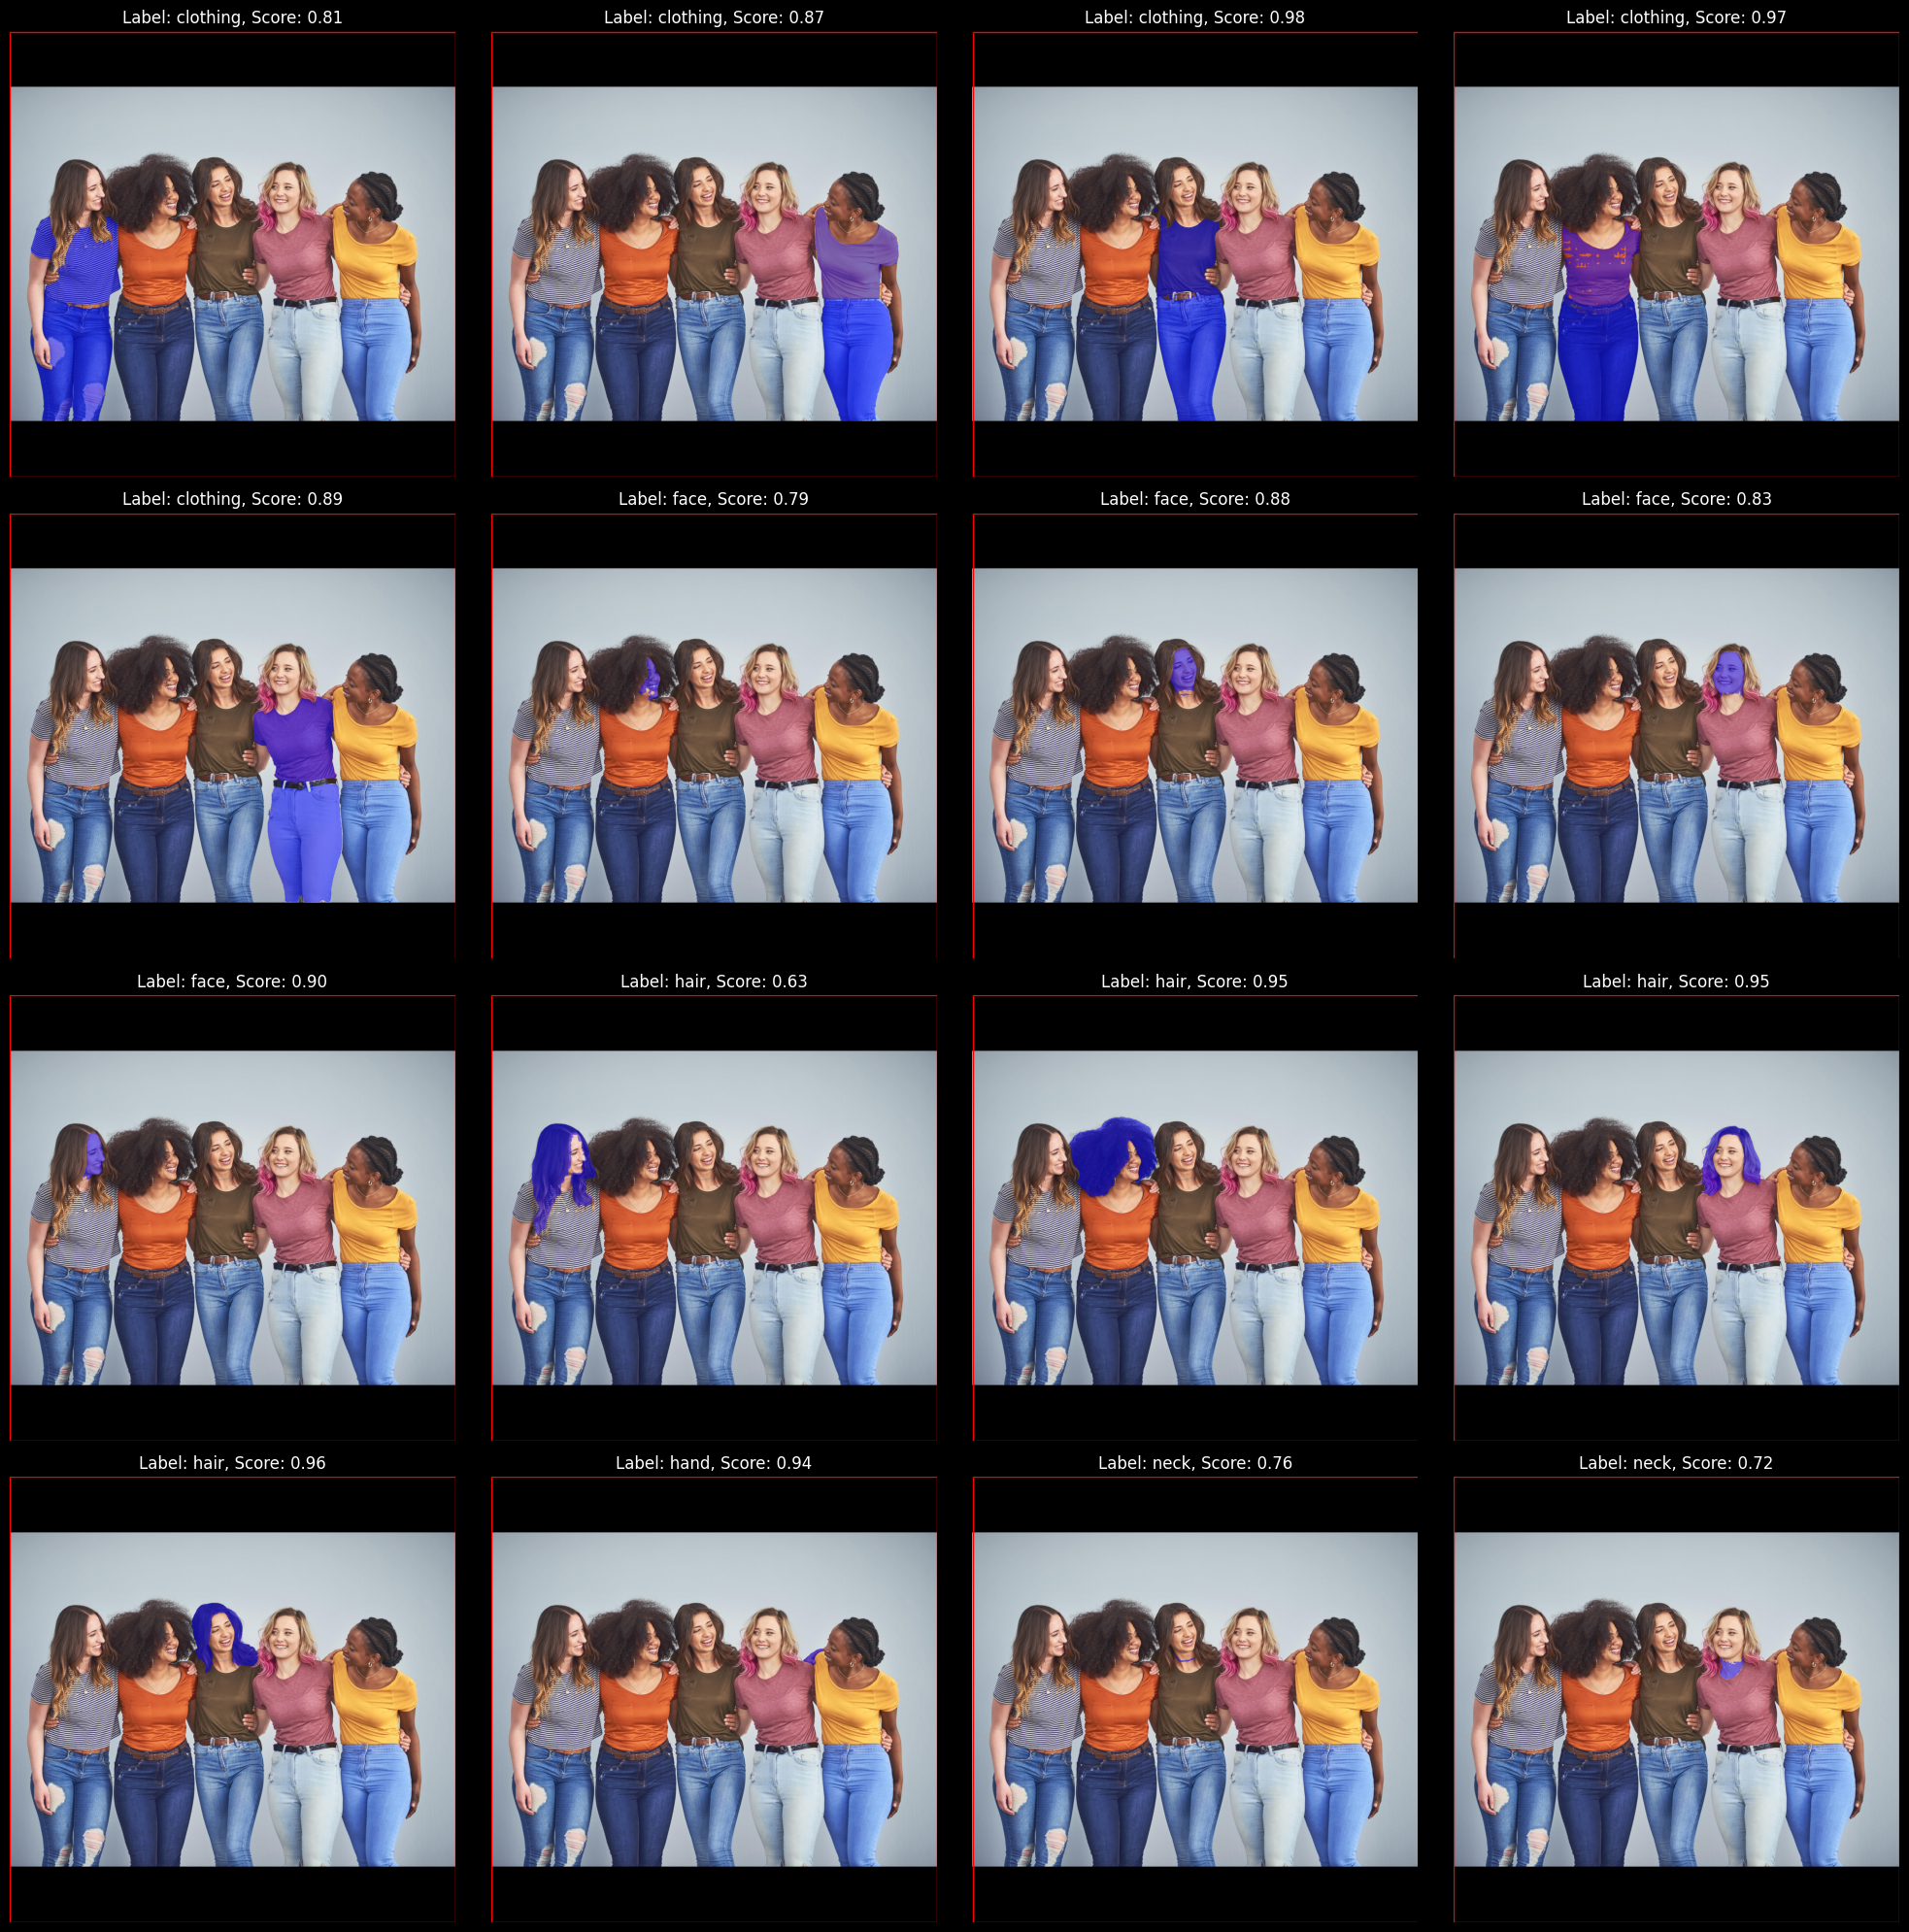

In [42]:
text_prompt = ["hair", "face", "neck", "arm", "hand", "back", "leg", "clothing", "phone", "hat", "foot"]

text_prompt = ".".join(text_prompt)

labels_dict = {prompt.strip(): idx for idx, prompt in enumerate(text_prompt.split("."))}


url = "https://static.independent.co.uk/s3fs-public/thumbnails/image/2020/03/05/10/istock-1137700343.jpg"

sam_results = get_masks(text_prompt, [url], labels_dict, box_threshold=0.3, text_threshold=0.35,labels_to_dedupe=None)

sam_results.display_results()

In [28]:
dino_results.scores

[tensor([0.6446, 0.5933, 0.4378, 0.4360])]

In [5]:
import numpy as np 

sam_scores = np.array(sam_results.scores)

dino_scores = dino_results.scores[0].cpu().numpy()

np.mean([sam_scores, dino_scores], axis=0)


array([0.80289525, 0.77978435, 0.66296597, 0.69143404])